In [11]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import solve, lstsq, eigvalsh, eigh
import warnings

# CVXPY is only used for optional quadratic-program cross-checks.
# The rest of the code does not depend on it.
try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception:
    _HAS_CVXPY = False

# Default plotting and display settings for interactive work.
plt.rcParams["figure.dpi"] = 130
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

# Base data directories used throughout the analysis.
DATA      = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA / "processed"
ANALYSIS  = DATA / "analysis"

# Training-period universe membership and weekly core panels.
UNIV_TRAIN_FILE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"
CORE_DEFAULT    = PROCESSED / "crsp_weekly_core.parquet"
CORE_ALT_B      = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"

# Training window and as-of date for kernel construction.
ASOF_DATE   = pd.Timestamp("2018-06-29")
TRAIN_START = pd.Timestamp("1997-01-01")
TRAIN_END   = ASOF_DATE

# Choice of dependence kernel and its estimation settings.
# By default this uses normalized MI; flip PREFER_MI to work directly with MI in bits.
PREFER_MI   = False
K_NEIGH     = 6
MIN_OVERLAP = 156
NORM_TAG    = "sqrt"

# Expected filenames for the precomputed MI/NMI artifacts.
NMI_FILE = ANALYSIS / f"nmi_tier1_asof{ASOF_DATE:%Y%m%d}_k{K_NEIGH}_min{MIN_OVERLAP}_{NORM_TAG}.parquet"
MI_FILE  = ANALYSIS / f"mi_bits_tier1_asof{ASOF_DATE:%Y%m%d}_k{K_NEIGH}_min{MIN_OVERLAP}_{NORM_TAG}.parquet"

# Regularization and conditioning controls for the kernel matrix.
RIDGE_MIN_EIG = 1e-6
KAPPA_MAX     = 1e8

In [13]:
def _ensure_df_square(df: pd.DataFrame, name="M") -> pd.DataFrame:
    # Make sure the matrix is square on a consistent label set.
    assert isinstance(df, pd.DataFrame), f"{name} must be a DataFrame"
    if not df.index.equals(df.columns):
        common = df.index.intersection(df.columns)
        df = df.loc[common, common].copy()
    return df

def sanitize_kernel(df: pd.DataFrame, *, assume_nmi: bool) -> pd.DataFrame:
    """
    Clean up a kernel matrix so downstream linear algebra behaves.

    Policy:
      - drop non-finite entries to 0
      - enforce symmetry
      - force diagonal to 0
      - if assume_nmi: clip into [0, 1]
      - else (raw MI): floor negatives to 0 (small-sample noise)
    """
    df = _ensure_df_square(df, "Kernel")
    A  = df.to_numpy(dtype="float64", copy=True)

    bad = ~np.isfinite(A)
    if bad.any():
        print(f"[sanitize] non-finite → 0 (count={int(bad.sum())})")
        A[bad] = 0.0

    if assume_nmi:
        A = np.clip(A, 0.0, 1.0)
    else:
        A = np.maximum(A, 0.0)

    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)

    # Basic diagnostics so it's obvious if something went wrong upstream.
    sym_err = float(np.max(np.abs(A - A.T)))
    print(f"[sanitize] sym_err={sym_err:.2e} | diag set to 0 | min={A.min():.4e} | max={A.max():.4e}")
    return pd.DataFrame(A, index=df.index, columns=df.columns)

def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    # Eigenvalue clip to enforce PSD (optionally with a small minimum eigenvalue).
    A = 0.5*(A + A.T)
    w, V = eigh(A)
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5*(B + B.T)

def choose_ridge(Qpsd: np.ndarray, target_min: float, kappa_max: float, max_steps: int = 12) -> float:
    # Find the smallest ridge (power-of-10 grid) that hits both min-eig and conditioning targets.
    w = eigvalsh(Qpsd)
    if (w[0] >= target_min) and (w[-1] / max(w[0], 1e-16) <= kappa_max):
        return 0.0
    ridge = 1e-8
    for _ in range(max_steps):
        w2 = eigvalsh(Qpsd + ridge*np.eye(Qpsd.shape[0]))
        if (w2[0] >= target_min) and (w2[-1]/w2[0] <= kappa_max):
            return ridge
        ridge *= 10.0
    return ridge

def redundancy_J(Q: np.ndarray, b: np.ndarray) -> float:
    # Quadratic redundancy objective: 0.5 * b' Q b.
    return 0.5 * float(b @ (Q @ b))

def sigma_Q(Q: np.ndarray, b: np.ndarray) -> float:
    # Quadratic form turned into a standard deviation-like scale.
    return float(np.sqrt(max(b @ (Q @ b), 0.0)))

def build_asof_label_map(univ_train_path: Path) -> dict:
    """
    Build PERMNO → label at ASOF_DATE.

    Label rule: uppercase ticker when available, else 'PERMNO_<id>'.
    """
    uni = pd.read_parquet(univ_train_path).copy()
    uni["date"]   = pd.to_datetime(uni["date"], errors="coerce")
    uni["permno"] = pd.to_numeric(uni["permno"], errors="coerce").astype("Int64")

    # Take the ASOF_DATE snapshot if present; otherwise take the last snapshot <= ASOF_DATE.
    if (uni["date"] == ASOF_DATE).any():
        slic = uni.loc[uni["date"].eq(ASOF_DATE)]
    else:
        last_d = uni.loc[uni["date"] <= ASOF_DATE, "date"].max()
        slic   = uni.loc[uni["date"].eq(last_d)]
    slic = slic.loc[slic["in_universe"].fillna(False)]

    tkr = slic.get("ticker")
    if tkr is not None:
        slic["ticker"] = slic["ticker"].fillna("").astype(str).str.upper()
    else:
        slic["ticker"] = ""

    def make_label(row):
        if row["ticker"].strip():
            return row["ticker"].upper()
        return f"PERMNO_{int(row['permno'])}"

    labels = slic.assign(label=slic.apply(make_label, axis=1))
    return dict(zip(labels["permno"].astype(int), labels["label"]))

def load_train_returns(core_default: Path, core_alt_b: Path) -> pd.DataFrame:
    """
    Load training-period returns from the weekly core panel.

    Output is a long table with: ['date', 'permno', 'ret_used'].
    """
    core_path = core_alt_b if core_alt_b.exists() else core_default
    core = pd.read_parquet(core_path).copy()
    core["date"]   = pd.to_datetime(core["date"], errors="coerce")
    core["permno"] = pd.to_numeric(core["permno"], errors="coerce").astype("Int64")
    if "ticker" in core.columns:
        core["ticker"] = core["ticker"].astype(str).str.upper()

    core = core[(core["date"] >= TRAIN_START) & (core["date"] <= TRAIN_END)]

    # Prefer total return if it's present; otherwise use raw return.
    ret_col = "ret_total" if "ret_total" in core.columns else ("ret" if "ret" in core.columns else None)
    assert ret_col is not None, "No 'ret_total' or 'ret' in core weekly panel."
    return core.rename(columns={ret_col: "ret_used"})[["date","permno","ret_used"]]

def mu_vector_from_core(core_long: pd.DataFrame, label2permno: dict, kernel_labels: list) -> pd.Series:
    """
    Compute μ (weekly arithmetic mean of simple returns) aligned to the kernel labels.
    """
    mu_by_permno = (core_long[["permno","ret_used"]]
                    .dropna()
                    .groupby("permno", observed=True)["ret_used"]
                    .mean().astype(float))

    # Invert the PERMNO→label map so we can align kernel labels back to PERMNOs.
    inv = {v: k for (k, v) in label2permno.items()}
    label_to_permno = {}
    for lbl in kernel_labels:
        if lbl in inv:
            label_to_permno[lbl] = inv[lbl]
        else:
            m = re.match(r"PERMNO_(\d+)$", str(lbl))
            if m:
                label_to_permno[lbl] = int(m.group(1))

    mu_vals = []
    miss = 0
    for lbl in kernel_labels:
        p = label_to_permno.get(lbl)
        if (p is None) or (p not in mu_by_permno.index):
            mu_vals.append(np.nan); miss += 1
        else:
            mu_vals.append(float(mu_by_permno.loc[p]))
    if miss:
        print(f"[μ] missing μ for {miss}/{len(kernel_labels)} labels (computed from TRAIN core).")
    return pd.Series(mu_vals, index=kernel_labels, name="mu_weekly")

In [15]:
# Load kernel, sanitize, PSD+ridge

# Pick which kernel artifact to load (preference order depends on PREFER_MI and file availability).
if PREFER_MI and MI_FILE.exists():
    R_named = pd.read_parquet(MI_FILE)
    kernel_src = "MI (bits)"
elif NMI_FILE.exists():
    R_named = pd.read_parquet(NMI_FILE)
    kernel_src = "NMI"
elif MI_FILE.exists():
    R_named = pd.read_parquet(MI_FILE)
    kernel_src = "MI (bits)"
else:
    raise FileNotFoundError("Neither NMI nor MI kernel file was found in ANALYSIS.")

print(f"[kernel] loaded {kernel_src}: shape={R_named.shape}")

# Clean up the matrix before linear algebra: finite, symmetric, and a zero diagonal.
# NMI gets clipped into [0,1]; MI gets floored at 0 to kill tiny negative noise.
Q_df = sanitize_kernel(R_named, assume_nmi=(kernel_src == "NMI"))

# Project to PSD and then add just enough ridge to control conditioning.
Q_psd = nearest_psd(Q_df.to_numpy(copy=True), eps_eig=0.0)
ridge = choose_ridge(Q_psd, target_min=RIDGE_MIN_EIG, kappa_max=KAPPA_MAX)
Q_reg = Q_psd + ridge*np.eye(Q_psd.shape[0])

# Quick numerical check: eigenvalues and implied condition number.
w = eigvalsh(Q_reg)
print(
    f"[Q] src={kernel_src} | ridge={ridge:.1e} | eig_min={w.min():.3e} | "
    f"eig_max={w.max():.3e} | cond≈{w.max()/w.min():.2e}"
)

labels = list(Q_df.index)
n = len(labels)

[kernel] loaded NMI: shape=(1000, 1000)
[sanitize] non-finite → 0 (count=93648)
[sanitize] sym_err=0.00e+00 | diag set to 0 | min=0.0000e+00 | max=5.9063e-01
[Q] src=NMI | ridge=1.0e-05 | eig_min=1.000e-05 | eig_max=4.617e+01 | cond≈4.62e+06


In [23]:
import re

# Pull the ASOF universe membership list from the universe parquet.
uni = pd.read_parquet(UNIV_TRAIN_FILE).copy()
uni["date"]   = pd.to_datetime(uni["date"], errors="coerce")
uni["permno"] = pd.to_numeric(uni["permno"], errors="coerce").astype("Int64")

# Use the ASOF_DATE snapshot if it exists; otherwise fall back to the last snapshot <= ASOF_DATE.
if (uni["date"] == ASOF_DATE).any():
    u_asof = uni.loc[(uni["date"] == ASOF_DATE) & uni["in_universe"].fillna(False), "permno"]
else:
    last_d = uni.loc[uni["date"] <= ASOF_DATE, "date"].max()
    u_asof = uni.loc[(uni["date"] == last_d) & uni["in_universe"].fillna(False), "permno"]

permnos_asof = pd.Index(u_asof.dropna().astype(int).unique(), dtype=int)
print(f"[universe] ASOF PERMNOs: {len(permnos_asof)}")

# Build a PERMNO ↔ ticker mapping from the weekly core, using the last observation <= ASOF_DATE.
core_full = pd.read_parquet(CORE_ALT_B if CORE_ALT_B.exists() else CORE_DEFAULT).copy()
core_full["date"]   = pd.to_datetime(core_full["date"], errors="coerce")
core_full["permno"] = pd.to_numeric(core_full["permno"], errors="coerce").astype("Int64")
core_full = core_full[core_full["permno"].isin(permnos_asof)]

if "ticker" in core_full.columns:
    core_full["ticker"] = core_full["ticker"].astype(str).str.upper()
else:
    core_full["ticker"] = ""

snap = (core_full[core_full["date"] <= ASOF_DATE]
        .sort_values(["permno","date"])
        .groupby("permno", observed=True).tail(1))

permno2tkr = dict(zip(snap["permno"].astype(int), snap["ticker"].astype(str)))

# Some tickers collide across PERMNOs; only keep the ones that map uniquely.
tkr_counts = pd.Series(list(permno2tkr.values())).value_counts()
ticker2permno = {t: p for p, t in permno2tkr.items() if t and tkr_counts[t] == 1}

print(f"[maps] permno→ticker: {len(permno2tkr)} | unique ticker→permno: {len(ticker2permno)}")

# Convert a kernel label back into a PERMNO using a few common patterns.
def label_to_permno(lbl: str) -> int | None:
    s = str(lbl)

    # Common label formats: "PERMNO_12345", variants with separators, or labels ending in digits.
    m = re.search(r"PERMNO[_\-\s]*(\d{4,7})$", s, flags=re.IGNORECASE)
    if m:
        return int(m.group(1))
    m = re.search(r"(\d{4,7})\s*$", s)
    if m:
        return int(m.group(1))

    # Otherwise, treat the leading token as the ticker (split on dash-like characters).
    tkr = s.split("—")[0].split("–")[0].split("-")[0].strip().upper()
    if tkr in ticker2permno:
        return int(ticker2permno[tkr])

    # If the ticker isn't unique, only accept it if it maps to exactly one PERMNO here.
    candidates = [p for p, t in permno2tkr.items() if t == tkr]
    if len(candidates) == 1:
        return int(candidates[0])
    return None

label2permno = {lbl: label_to_permno(lbl) for lbl in labels}
covered = {lbl: p for lbl, p in label2permno.items() if p is not None}
print(f"[align] mapped {len(covered)}/{len(labels)} labels to PERMNOs")

# Compute μ by PERMNO on the training window, then align it to the kernel label order.
core_long = load_train_returns(CORE_DEFAULT, CORE_ALT_B)  # ['date','permno','ret_used']
mu_by_permno = (core_long[["permno","ret_used"]]
                .dropna()
                .groupby("permno", observed=True)["ret_used"]
                .mean().astype(float))

mu_vals = []
for lbl in labels:
    p = label2permno.get(lbl)
    if (p is None) or (p not in mu_by_permno.index):
        mu_vals.append(np.nan)
    else:
        mu_vals.append(float(mu_by_permno.loc[p]))

mu_ser = pd.Series(mu_vals, index=labels, name="mu_weekly")
n_missing = int(mu_ser.isna().sum())
print(f"[μ] built μ_weekly for {len(labels)-n_missing}/{len(labels)} labels (missing={n_missing})")

# Handy numeric view for optimizers that want a dense array.
mu = mu_ser.to_numpy(dtype=float)

[universe] ASOF PERMNOs: 1000
[maps] permno→ticker: 1000 | unique ticker→permno: 1000
[align] mapped 1000/1000 labels to PERMNOs
[μ] built μ_weekly for 1000/1000 labels (missing=0)


In [25]:
# Solve GMRP (closed-form + optional QP cross-check) & save

# Unconstrained GMRP has a closed form: b ∝ Q^{-1} 1, normalized so weights sum to 1.
ones = np.ones(n)
try:
    x = solve(Q_reg, ones)
except np.linalg.LinAlgError:
    x, *_ = lstsq(Q_reg, ones, rcond=None)

b_gmrp = x / x.sum()
J_gmrp = redundancy_J(Q_reg, b_gmrp)
sig_gmrp = sigma_Q(Q_reg, b_gmrp)

# Sanity check: solve the same problem as a QP and compare.
if _HAS_CVXPY:
    b = cp.Variable(n)
    obj  = 0.5 * cp.quad_form(b, Q_reg)
    cons = [cp.sum(b) == 1]
    prob = cp.Problem(cp.Minimize(obj), cons)
    solver = next((s for s in ["OSQP","SCS","CLARABEL","ECOS"] if s in set(cp.installed_solvers())), None)
    kw = dict(verbose=False, warm_start=True)
    if solver == "OSQP": kw.update(dict(eps_abs=1e-8, eps_rel=1e-8, max_iter=200000, polish=True))
    if solver == "SCS":  kw.update(dict(eps=1e-5, max_iters=200000))
    _ = prob.solve(solver=solver, **kw)
    if prob.status in ("optimal","optimal_inaccurate") and b.value is not None:
        b_qp = np.array(b.value).ravel()
        b_qp = b_qp / b_qp.sum()
        if not np.allclose(b_qp, b_gmrp, atol=1e-6, rtol=1e-6):
            warnings.warn("QP and closed-form differ beyond 1e-6; using QP weights.")
            b_gmrp = b_qp
            J_gmrp = redundancy_J(Q_reg, b_gmrp)
            sig_gmrp = sigma_Q(Q_reg, b_gmrp)

# Compute portfolio mean return using μ when it's available (and renormalize if some entries are missing).
def portfolio_mean(mu_series: pd.Series, b: np.ndarray, labels: list) -> float | None:
    s = mu_series.reindex(labels)
    mask = s.notna().to_numpy()
    if mask.sum() == 0:
        return None
    if mask.sum() < len(labels):
        bw = b[mask] / b[mask].sum()
        return float(np.dot(s.to_numpy()[mask], bw))
    return float(np.dot(s.to_numpy(), b))

mu_gmrp = portfolio_mean(mu_ser, b_gmrp, labels)

# Save weights with a filename that encodes the run configuration.
b_gmrp_ser = pd.Series(b_gmrp, index=labels, name="weight")
L1_gmrp = float(np.abs(b_gmrp).sum())

tag = f"asof{ASOF_DATE:%Y%m%d}_top{n}_ridge{ridge:.0e}"
out_path = ANALYSIS / f"b_gmrp_unconstrained_qp_{tag}.parquet"
b_gmrp_ser.to_frame().to_parquet(out_path)

print(f"[GMRP] saved → {out_path}")
print(f"[GMRP] J=½ b'Qb={J_gmrp:.6e} | σ_Q={sig_gmrp:.6e} | L1={L1_gmrp:.3f} | longs={(b_gmrp>0).sum()} | shorts={(b_gmrp<0).sum()}")
if mu_gmrp is not None:
    print(f"[GMRP] μ_weekly={mu_gmrp:.6e}  (TRAIN 1997–2018)")

[GMRP] saved → C:\Users\bseis\ABthesis\data\analysis\b_gmrp_unconstrained_qp_asof20180629_top1000_ridge1e-05.parquet
[GMRP] J=½ b'Qb=8.440924e-08 | σ_Q=4.108753e-04 | L1=2.198 | longs=580 | shorts=420
[GMRP] μ_weekly=5.178427e-03  (TRAIN 1997–2018)



Top longs:


,weight
15724,0.016882
16498,0.016882
15980,0.016882
15921,0.016882
16347,0.016882
15535,0.016882
16087,0.016882
16736,0.016882
15707,0.016882
16021,0.016882



Top shorts:


,weight
90569,-0.006258
15408,-0.006110
91975,-0.005628
92570,-0.005331
90952,-0.005327
91392,-0.005127
88853,-0.005028
90880,-0.004996
91461,-0.004981
90441,-0.004833


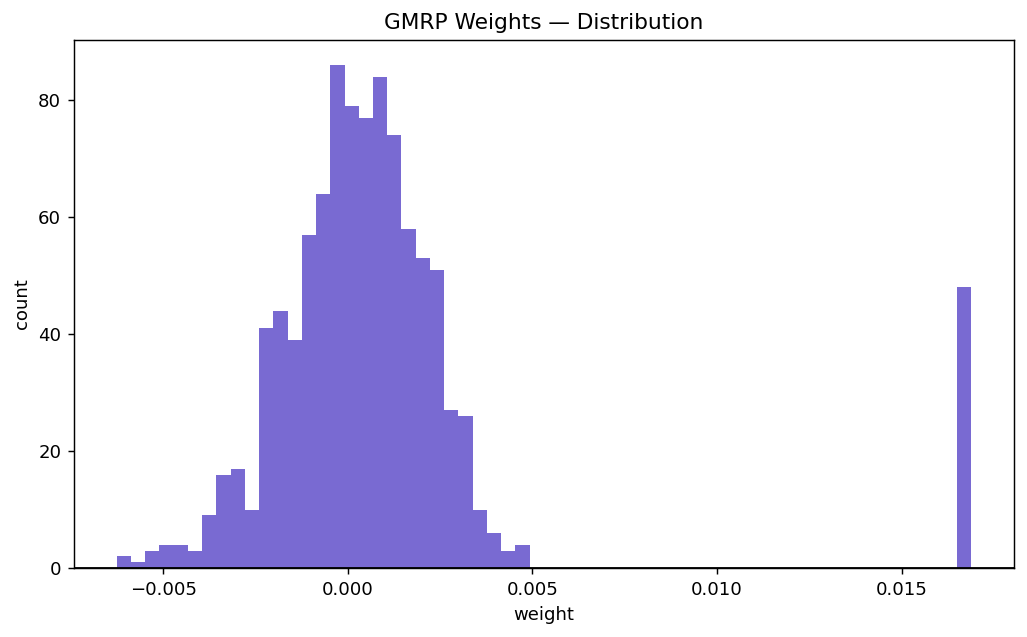

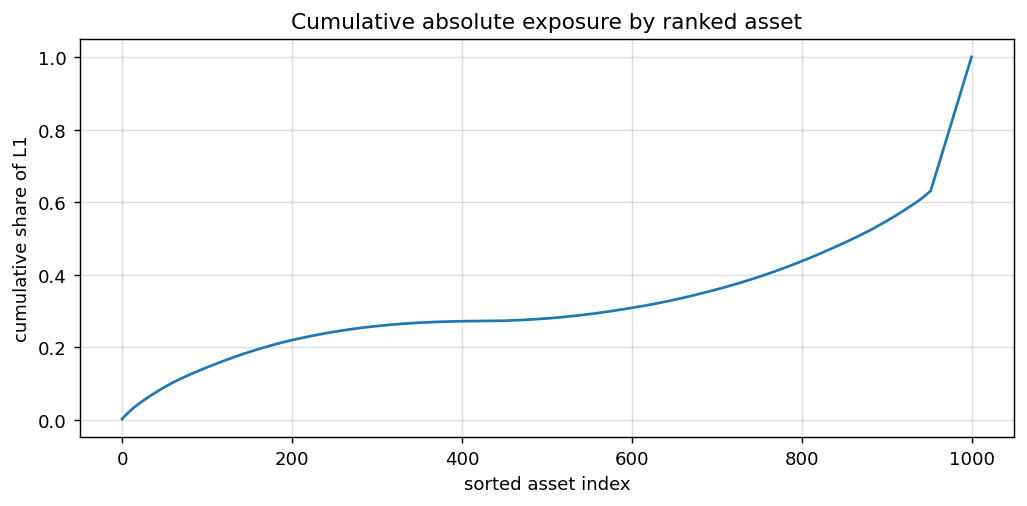

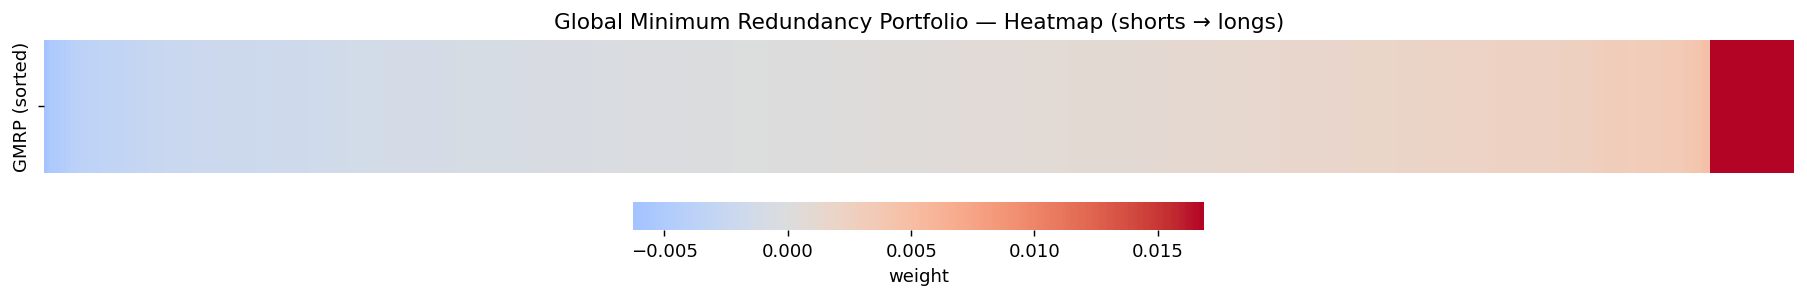

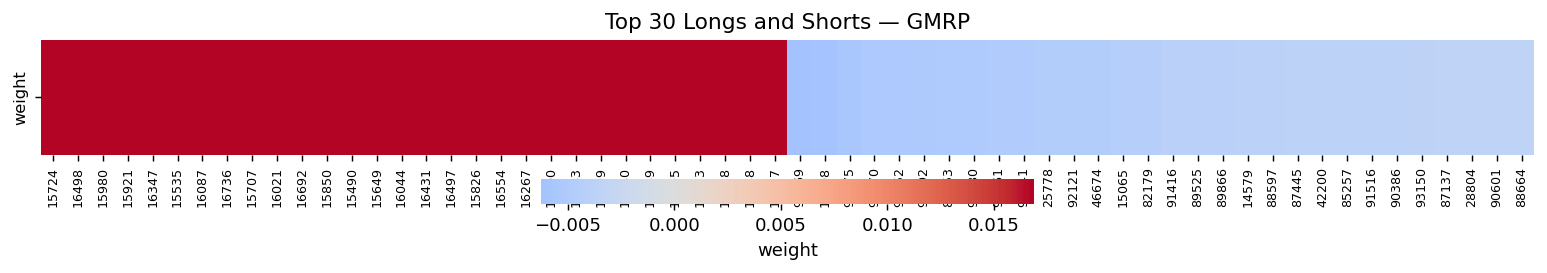

In [27]:
# Tables & visuals for GMRP

# Quick look at the biggest long and short positions.
TOP = 30
top_longs  = b_gmrp_ser.sort_values(ascending=False).head(TOP)
top_shorts = b_gmrp_ser.sort_values(ascending=True).head(TOP)

print("\nTop longs:")
display(top_longs.to_frame("weight"))
print("\nTop shorts:")
display(top_shorts.to_frame("weight"))

# Distribution of weights (helps diagnose extreme tails and overall leverage structure).
plt.figure(figsize=(8,5))
plt.hist(b_gmrp_ser.values, bins=60, color="slateblue", alpha=0.90)
plt.axhline(0, color="black", lw=1)
plt.title("GMRP Weights — Distribution")
plt.xlabel("weight"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Concentration curve: how quickly gross exposure accumulates across names.
w_sorted = b_gmrp_ser.sort_values()
cum_abs  = np.cumsum(np.abs(w_sorted.values))
plt.figure(figsize=(8,4))
plt.plot(cum_abs / cum_abs[-1])
plt.title("Cumulative absolute exposure by ranked asset")
plt.xlabel("sorted asset index"); plt.ylabel("cumulative share of L1")
plt.grid(alpha=0.4)
plt.tight_layout(); plt.show()

# Heatmaps are convenient for inspection, but keep seaborn optional.
try:
    import seaborn as sns

    # Single-row heatmap for the full vector (ordered shorts → longs).
    plt.figure(figsize=(14, 2.4))
    sns.heatmap(
        w_sorted.values[np.newaxis,:],
        cmap="coolwarm",
        center=0,
        xticklabels=False,
        yticklabels=["GMRP (sorted)"],
        cbar_kws={"orientation":"horizontal","label":"weight"},
    )
    plt.title("Global Minimum Redundancy Portfolio — Heatmap (shorts → longs)")
    plt.tight_layout(); plt.show()

    # Zoomed view: only the biggest longs and shorts.
    subset = pd.concat([top_longs, top_shorts])
    plt.figure(figsize=(12, 2.2))
    sns.heatmap(
        subset.values[np.newaxis,:],
        cmap="coolwarm",
        center=0,
        xticklabels=subset.index,
        yticklabels=["weight"],
        cbar_kws={"orientation":"horizontal","label":"weight"},
    )
    plt.title(f"Top {TOP} Longs and Shorts — GMRP")
    plt.xticks(rotation=90, fontsize=7); plt.yticks(fontsize=9)
    plt.tight_layout(); plt.show()
except Exception:
    warnings.warn("seaborn not available; skipping heatmaps.")

In [31]:
# Reload weights (or use the in-memory result) and enforce exact normalization.
w = b_gmrp_ser.copy().astype(float)
w = w / w.sum()

n = len(w)
print(
    f"[GMRP] N={n} | sum={w.sum():.6f} | L1={float(np.abs(w).sum()):.3f} "
    f"| min={w.min():.4g} | max={w.max():.4g}"
)

# Check how many names end up essentially equal-weighted.
eq_1_over_n = np.isclose(w.values, 1.0 / n, atol=1e-6)
print(f"[GMRP] # near 1/N: {eq_1_over_n.sum()} (1/N = {1.0/n:.6f})")

# Closed-form cross-check: unconstrained GMRP satisfies b ∝ Q^{-1} 1.
one = np.ones(n)
try:
    b_cf = np.linalg.solve(Q_reg, one)
    b_cf /= b_cf.sum()
except np.linalg.LinAlgError:
    b_cf, *_ = np.linalg.lstsq(Q_reg, one, rcond=None)
    b_cf /= b_cf.sum()

# Compare the final weights to the closed-form solution.
diff = np.linalg.norm(w.values - b_cf, ord=2)
print(f"[GMRP] ||w_qp - w_closedform||₂ = {diff:.3e}")

[GMRP] N=1000 | sum=1.000000 | L1=2.198 | min=-0.006258 | max=0.01688
[GMRP] # near 1/N: 1 (1/N = 0.001000)
[GMRP] ||w_qp - w_closedform||₂ = 2.711e-17


[reload] b_gmrp_unconstrained_qp_asof20180629_top1000_ridge1e-05.parquet | N=1000 | sum=1.000000


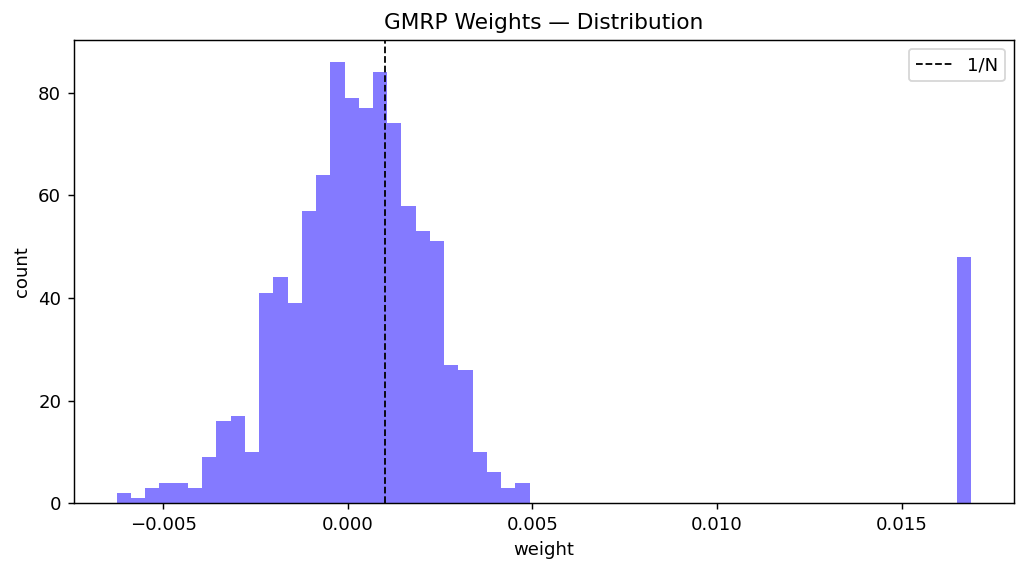

In [33]:
# Reload the most recently saved GMRP weights from disk so everything below
# reflects what was actually written, not whatever happens to be in memory.
latest = sorted(ANALYSIS.glob("b_gmrp_unconstrained_qp_*.parquet"))[-1]
w = pd.read_parquet(latest)["weight"].astype(float)

# Enforce exact normalization (defensive against tiny numerical drift).
w = w / w.sum()
print(f"[reload] {latest.name} | N={len(w)} | sum={w.sum():.6f}")

# Visual check: weight distribution with an equal-weight (1/N) reference.
plt.figure(figsize=(8,4.5))
plt.hist(w.values, bins=60, color="#6F63FF", alpha=0.85)
plt.axvline(1.0/len(w), color="k", ls="--", lw=1, label="1/N")
plt.title("GMRP Weights — Distribution")
plt.xlabel("weight")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Normalize weights defensively so they sum to exactly one.
w = b_gmrp_ser.astype(float)
w = w / w.sum()
n = len(w)

# First-order optimality (KKT) check for the unconstrained problem.
# At the optimum, Qw should be proportional to the all-ones vector.
Qw = Q_reg @ w.values
lam = float(Qw.sum() / n)
kkt_resid = float(np.linalg.norm(Qw - lam * np.ones(n)))
print(f"[KKT] ||Qw - λ·1||₂ = {kkt_resid:.3e} (should be ~1e-10 or smaller)")

# Distributional diagnostics to understand weight concentration and tails.
pcts = np.percentile(w.values, [0.1, 1, 5, 50, 95, 99, 99.5, 99.9])
print(
    "[weights pctiles] "
    "0.1%={:.5f}, 1%={:.5f}, 5%={:.5f}, median={:.5f}, "
    "95%={:.5f}, 99%={:.5f}, 99.5%={:.5f}, 99.9%={:.5f}"
    .format(*pcts)
)

# Net long and short mass (useful sanity check for normalization).
pos = w[w > 0].sum()
neg = w[w < 0].sum()
print(f"[sign sums] sum(w⁺)={pos:.4f}, sum(w⁻)={neg:.4f} (should sum to 1)")

# Coverage of the largest long positions.
for k in [5, 10, 25, 50, 100]:
    cov = float(w.sort_values(ascending=False).head(k).sum())
    print(f"[top{k}] sum of top {k} longs = {cov:.4f}")

# Count how many names sit in the extreme right tail of the weight distribution.
for thr in [0.010, 0.0125, 0.015, 0.016, 0.0165]:
    cnt = int((w.values >= thr).sum())
    print(f"[tail] # weights ≥ {thr:.4f} = {cnt}")

[KKT] ||Qw - λ·1||₂ = 8.809e-17 (should be ~1e-10 or smaller)
[weights pctiles] 0.1%=-0.00611, 1%=-0.00471, 5%=-0.00296, median=0.00037, 95%=0.00467, 99%=0.01688, 99.5%=0.01688, 99.9%=0.01688
[sign sums] sum(w⁺)=1.5992, sum(w⁻)=-0.5992 (should sum to 1)
[top5] sum of top 5 longs = 0.0844
[top10] sum of top 10 longs = 0.1688
[top25] sum of top 25 longs = 0.4220
[top50] sum of top 50 longs = 0.8198
[top100] sum of top 100 longs = 0.9938
[tail] # weights ≥ 0.0100 = 48
[tail] # weights ≥ 0.0125 = 48
[tail] # weights ≥ 0.0150 = 48
[tail] # weights ≥ 0.0160 = 48
[tail] # weights ≥ 0.0165 = 48
